# Импортируем нужные библиотеки

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, metrics, tree, ensemble
from scipy.interpolate import griddata

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

import time

# Готовим данные

Генерируем выборку с помощью sklearn.datasets.make_regression (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) со следующими параметрами:
1. Наблюдений - 10 тысяч
2. Всех фичей - 100
3. Информативных фичей - 50

In [ ]:
regression_problem = datasets.make_regression(n_samples=10000, n_features=100,
                                              n_informative=50, random_state=42)

In [ ]:
regression_problem[0].shape

(10000, 100)

Разбиваем выборку на **train** и **test** в отношении 75:25.

In [ ]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_problem[0],
                                                                                    regression_problem[1],
                                                                                    test_size=0.25,
                                                                                    random_state=42)

# Строим модели

Рассматривается задача **регрессии**: по исходным признакам требуется восстановить непрерывный таргет.

**Цель**: минимизировать метрику **MSE** (среднеквадратическая ошибка).

В качестве максимальной ошибки будем рассматривать алгоритм, который выдает в качестве ответа константу - среднее значение таргета на обучающей выборке.

In [ ]:
round(metrics.mean_squared_error(test_labels, test_labels.shape[0] * [train_labels.mean()]))

147370

In [ ]:
def fit_and_metrics(estimator, train_data, train_labels, test_data, test_labels):
    start_time = time.time()
    estimator.fit(train_data, train_labels)
    print(f'Learning time = {round(time.time() - start_time, 3)} s')

    predictions = estimator.predict(train_data)
    print(f'Train: {round(metrics.accuracy_score(train_labels, predictions), 5)}')

    predictions = estimator.predict(test_data)
    print(f'Test: {round(metrics.accuracy_score(test_labels, predictions), 5)}')

    return estimator

## Дерево решений

***Задание 1.***

Требуется обучая деревья решений на трейне, подобрать гиперпараметры **max_depth** и **min_samples_leaf** так, чтобы **MSE** на тесте было меньше **130 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **15 000**.

Переберал гиперпараметры, останавился на этих трёх показательных

In [ ]:
tree_regressor_1 = tree.DecisionTreeRegressor(max_depth=5, min_samples_leaf=340, random_state=42)

tree_regressor_2 = tree.DecisionTreeRegressor(max_depth=4, min_samples_leaf=300, random_state=42)

tree_regressor_3 = tree.DecisionTreeRegressor(max_depth=4, min_samples_leaf=323, random_state=42)


start_time = time.time()
tree_regressor_1.fit(train_data, train_labels)
print(f'Learning time_1 = {round(time.time() - start_time, 3)} s')

start_time = time.time()
tree_regressor_2.fit(train_data, train_labels)
print(f'Learning time_2 = {round(time.time() - start_time, 3)} s')

start_time = time.time()
tree_regressor_3.fit(train_data, train_labels)
print(f'Learning time_3 = {round(time.time() - start_time, 3)} s')

Learning time_1 = 0.335 s
Learning time_2 = 0.326 s
Learning time_3 = 0.336 s


In [ ]:
predictions_1 = tree_regressor_1.predict(train_data)
train_tree_MSE_1 = metrics.mean_squared_error(train_labels, predictions_1)

predictions_1 = tree_regressor_2.predict(train_data)
train_tree_MSE_2 = metrics.mean_squared_error(train_labels, predictions_1)

predictions_1 = tree_regressor_3.predict(train_data)
train_tree_MSE_3 = metrics.mean_squared_error(train_labels, predictions_1)

In [ ]:
predictions_1 = tree_regressor_1.predict(test_data)
test_tree_MSE_1 = metrics.mean_squared_error(test_labels, predictions_1)

predictions_2 = tree_regressor_2.predict(test_data)
test_tree_MSE_2 = metrics.mean_squared_error(test_labels, predictions_2)

predictions_3 = tree_regressor_3.predict(test_data)
test_tree_MSE_3 = metrics.mean_squared_error(test_labels, predictions_3)

In [ ]:
if (test_tree_MSE_1 < 130000) and (test_tree_MSE_1 - train_tree_MSE_1 <= 15000):
    print(f'Вы восхитительны_1! Ведь у вас: test_tree_MSE_1 = {round(test_tree_MSE_1, 3)}, а разница MSE на train и test = {round(test_tree_MSE_1 - train_tree_MSE_1, 3)}')
else:
    print(f'Не с этими гипрепараметрами уж точно... test_tree_MSE_1 = {round(test_tree_MSE_1, 3)}, а разница MSE на train и test = {round(test_tree_MSE_1 - train_tree_MSE_1, 3)}')

if (test_tree_MSE_2 < 130000) and (test_tree_MSE_2 - train_tree_MSE_1 <= 15000):
    print(f'Вы восхитительны_2! Ведь у вас: test_tree_MSE_2 = {round(test_tree_MSE_2, 3)}, а разница MSE на train и test = {round(test_tree_MSE_2 - train_tree_MSE_2, 3)}')
else:
    print(f'Не с этими гипрепараметрами уж точно... test_tree_MSE_2 = {round(test_tree_MSE_2, 3)}, а разница MSE на train и test = {round(test_tree_MSE_2 - train_tree_MSE_2, 3)}')

if (test_tree_MSE_3 < 130000) and (test_tree_MSE_3 - train_tree_MSE_3 <= 15000):
    print(f'Вы восхитительны_3! Ведь у вас: test_tree_MSE_3 = {round(test_tree_MSE_3, 3)}, а разница MSE на train и test = {round(test_tree_MSE_3 - train_tree_MSE_3, 3)}')
else:
    print(f'Не с этими гипрепараметрами уж точно... test_tree_MSE_3 = {round(test_tree_MSE_3, 3)}, а разница MSE на train и test = {round(test_tree_MSE_3 - train_tree_MSE_3, 3)}')

Вы восхитительны_1! Ведь у вас: test_tree_MSE_1 = 129194.25, а разница MSE на train и test = 5691.868
Вы восхитительны_2! Ведь у вас: test_tree_MSE_2 = 127868.354, а разница MSE на train и test = 2974.186
Вы восхитительны_3! Ведь у вас: test_tree_MSE_3 = 127764.009, а разница MSE на train и test = 2669.727


In [ ]:
tree_regressor = tree_regressor_3

***Задание 2.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

**Ответ:**

Как и говорилось на семинаре, одними из ключевых гиперпараметров дерева решения являются глубина, а так же минимальное количество наблюдений, попадаемое в лист.

Можно заметить, что если сделать одинаковый *max_depth* и изменять *min_samples_leaf*, то обе метрики меняются, пока не приблизятся к каком-то оптимальному значению (в моём случае при max_depth = 4 оптимальным явилось значение *min_samples_leaf* = 323)

Не разумно ставить слишком большое значение *max_depth* - может произойти переобучение. При этом мне кажется, что если уж и выбирать *max_depth* большим, то нужно попробовать снижать значение *min_samples_leaf*.

Не разумно так же выбирать и *min_samples_leaf* слишком маленьким - будет переобучение - и достаточно большим - будет низкая точность.

В общем, нужен баланс.






***Задание 3.***

Визуализируйте построенное дерево. Можно воспользоваться методом, который был продемонстрирован на семинаре.

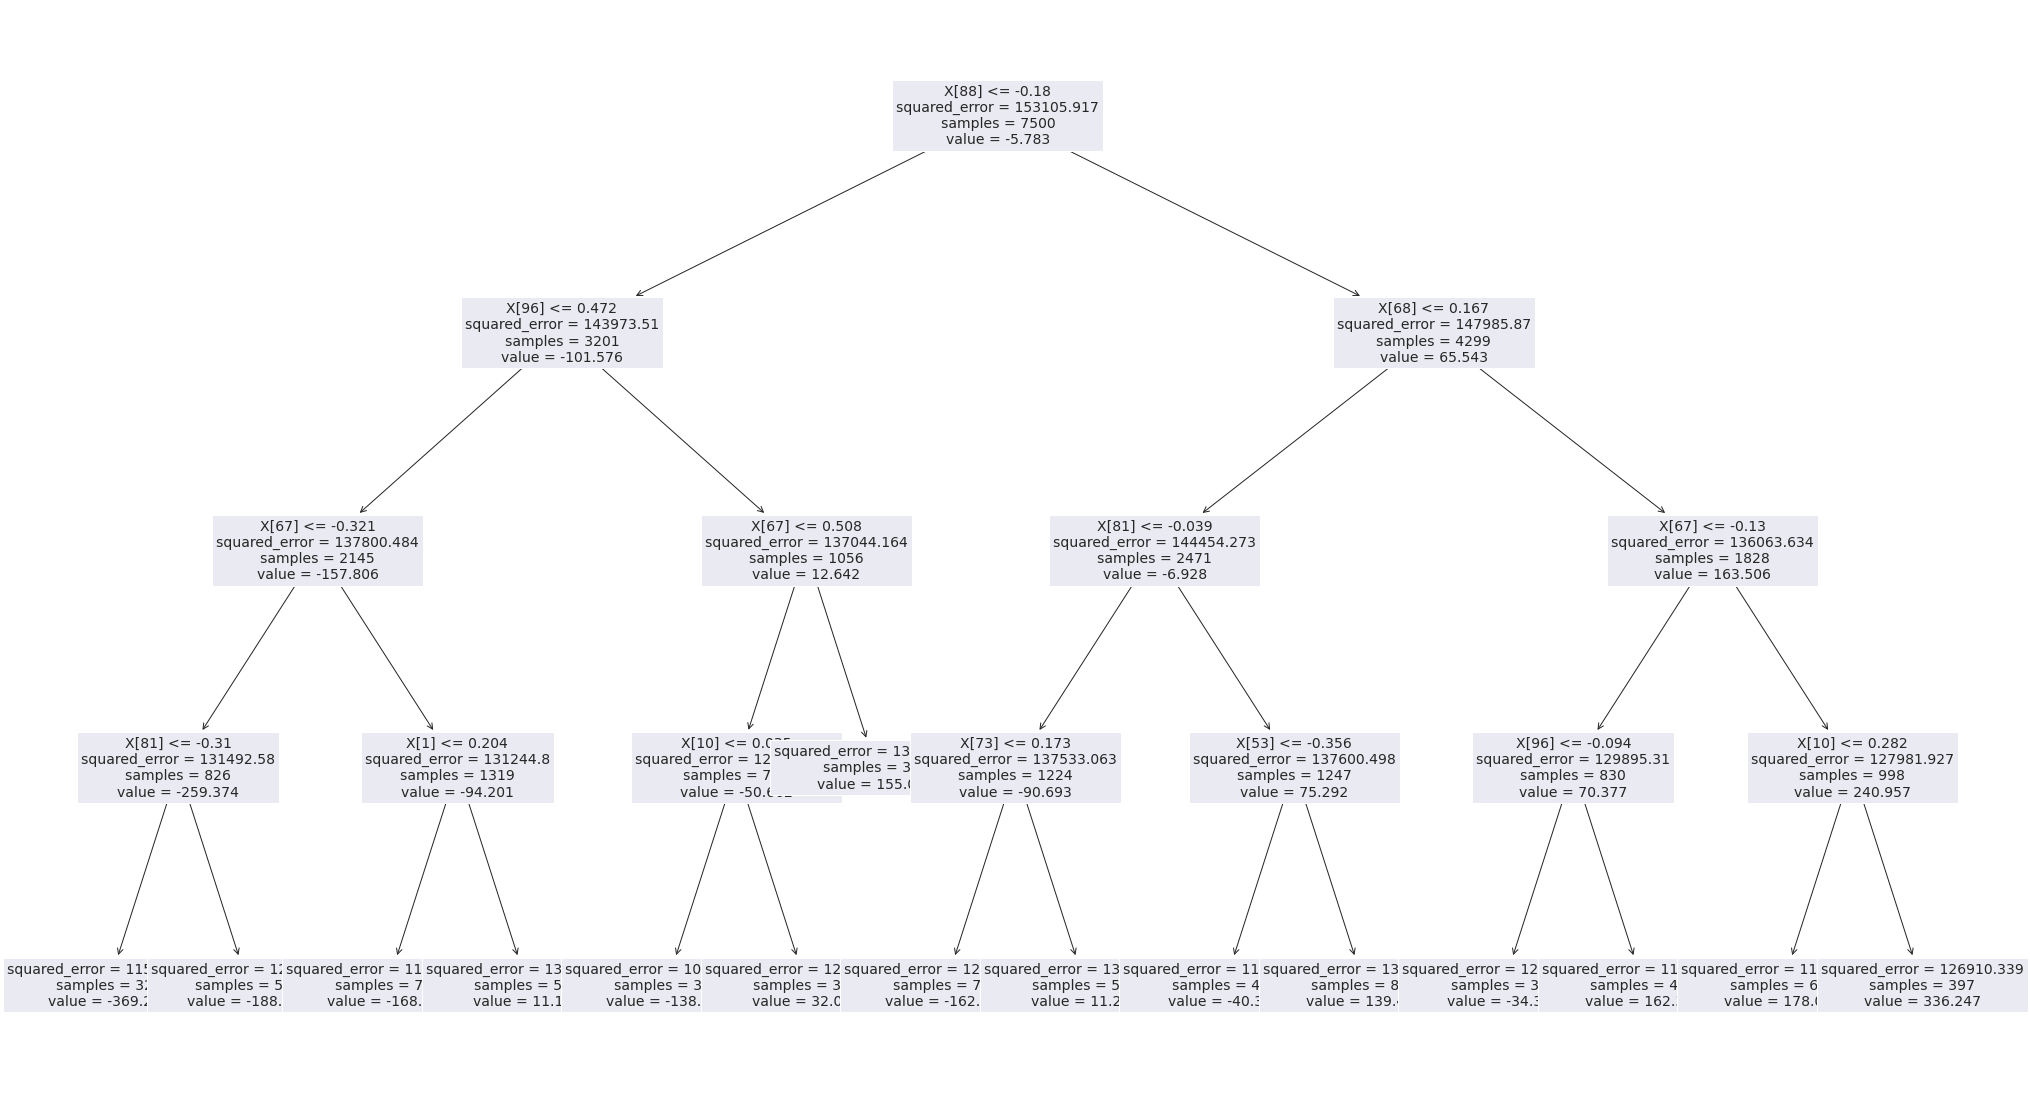

In [ ]:
plt.figure(figsize = (35, 20))
txt = tree.plot_tree(tree_regressor, fontsize=14)

***Задание 4.***

Далее посмотрим, как работает построенное дерево. Для этого выберем 2 самых значимых для дерева признака и визуализируем сплиты по ним. Можете использовать как указанную ниже функции, так и собственно написанные.

Нужно выбрать 2 признака и выполнить функцию для обучающей и тестовой выборок.

In [ ]:
importances = tree_regressor.feature_importances_


imp = sorted(range(len(importances)), key=lambda k: importances[k], reverse = True) #думал вывести первыедва значимых признака, но второй признак - 67 - во втором уровне не встречается и, кажется, стоит просто брать признак из второго уровня, который виден из графа. Хотя 67ой признак довольно значим, о чём свидетельствует его присутствие на 3ем уровне
imp[:5]

[88, 67, 68, 96, 81]

In [ ]:
def plot_decision_surface(i, j, data, labels, split_1, split_2, left_flg):
    """
        i - номер первого признака
        j - номер второго признака
        data - выборка с признаками
        labels - выборка с таргетом
        split_1 - значение из условия на первый признак
        split_2 - значение из условия на второй признак
        left_flg - флаг того, что второй признак рассматривается при невыполнении
        в дереве условия на первый признак
    """
    x = data[:, i]
    y = data[:, j]
    z = labels

    resolution = '50j'
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method = 'linear')

    plt.figure(figsize=(14, 10))
    plt.contourf(X, Y, Z, cmap='winter')
    plt.colorbar()
    plt.plot([split_1, split_1], [y.min(), y.max()], 'r', linewidth=5, label='First split')
    if left_flg:
        split_list = [x.min(), split_1]
    else:
        split_list = [split_1, x.max()]
    plt.plot(split_list, [split_2, split_2], 'm', linewidth=5, label='Second split')
    plt.legend()
    plt.xlabel(f'X[{i}]')
    plt.ylabel(f'X[{j}]')
    plt.show()

In [ ]:
first_feature_number = imp[0]
second_feature_number = 68

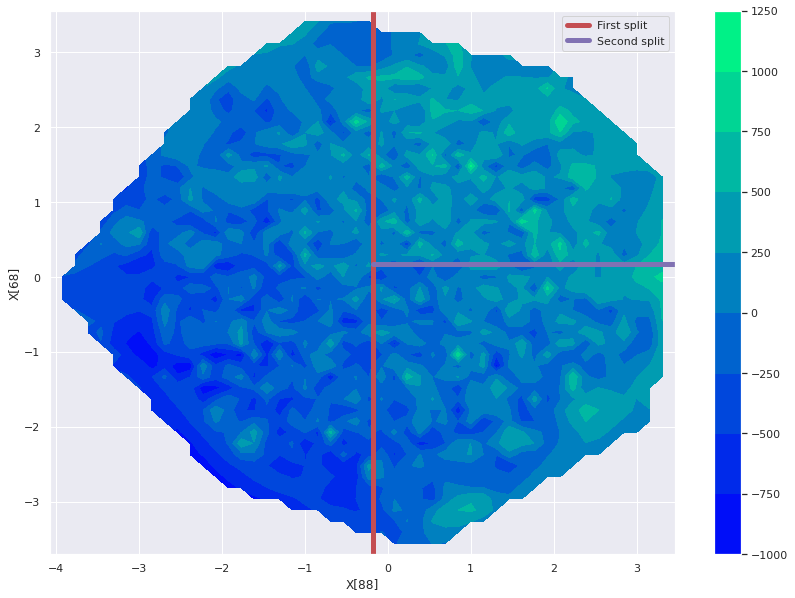

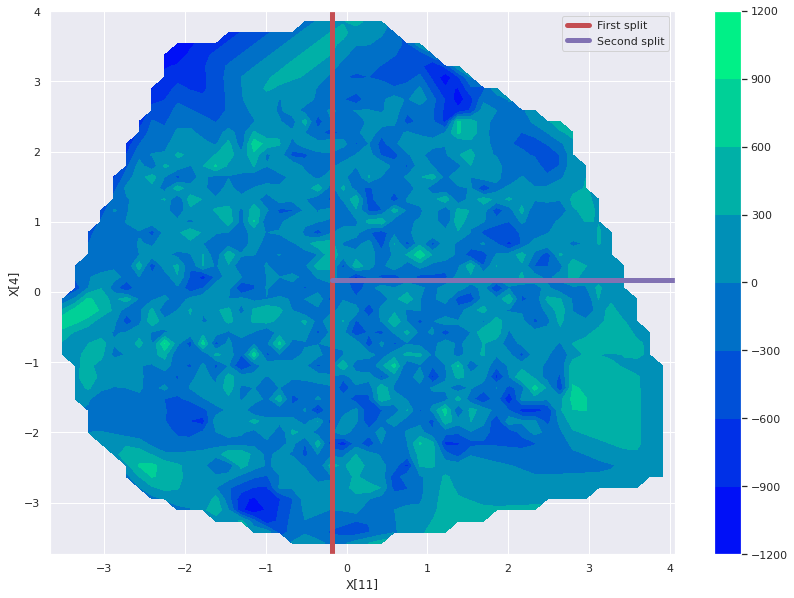

In [ ]:
plot_decision_surface(first_feature_number, second_feature_number, train_data, train_labels, -0.18, 0.167, 0), # ПО ЗНАЧИМЫМ
plot_decision_surface(11, 4, train_data, train_labels, -0.18, 0.167, 0)                                        # ПО СЛУЧАЙНЫМ

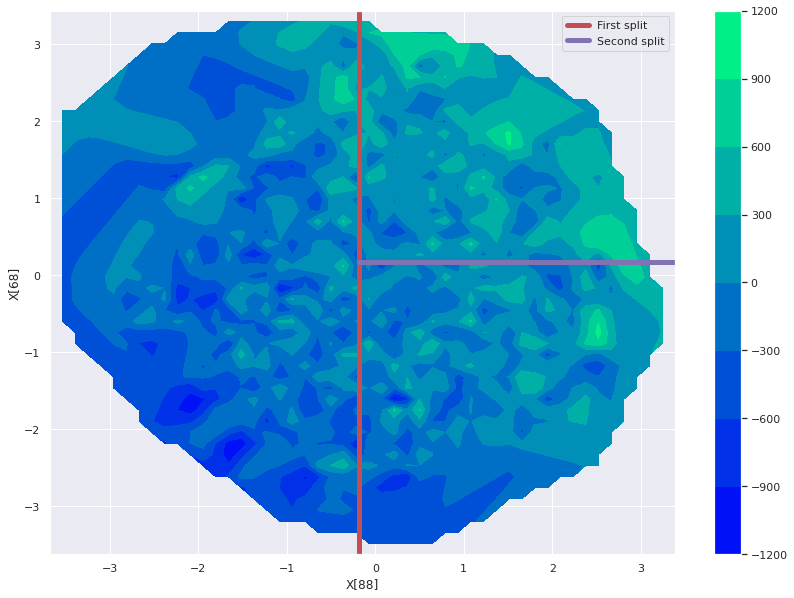

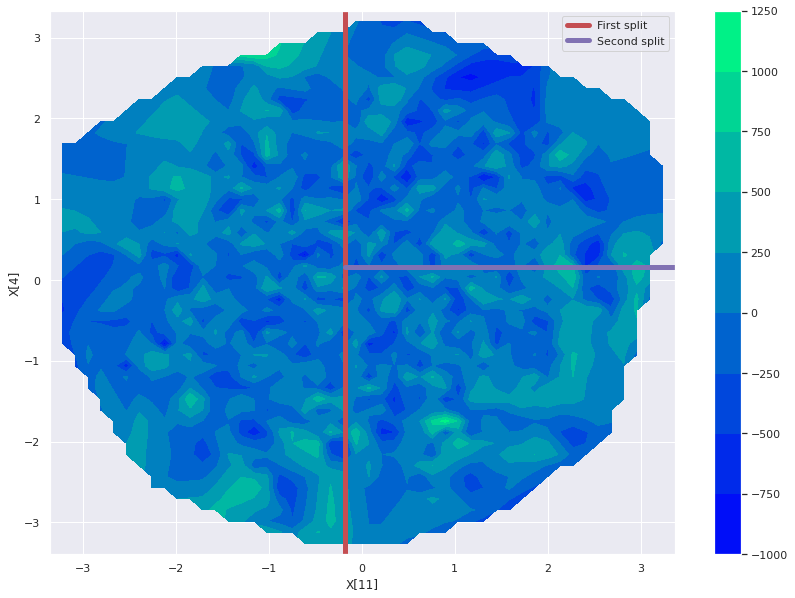

In [ ]:
plot_decision_surface(first_feature_number, second_feature_number, test_data, test_labels, -0.18, 0.167, 0), # ПО ЗНАЧИМЫМ
plot_decision_surface(11, 4, test_data, test_labels, -0.18, 0.167, 0)                                        # ПО СЛУЧАЙНЫМ

Как вы оцениваете разбиение выборок по двум сплитам из дерева?

**Ответ:**

Если выбирать два значимых признака, то видно, что выборка красиво бъётся по группам и классификатор находит оптимальное значение для параметров, чтобы задать условие в узле. Если же рассматривать какие-то случайные признаки, то из представления видно, что данные распределены очень хаотично - всё пятнисто и нет чёткого разделения на области, то есть данные разбиваются не так хорошо на группы, словом, слабая обобщающая способность.

## Случайный лес

***Задание 5.***

Задание, аналогичное второму:

Требуется обучая случайные леса на трейне, подобрать гиперпараметры **n_estimators**, **max_depth** и **min_samples_leaf** так, чтобы **MSE** на тесте было меньше **100 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **15 000**.

Опять же покажу на трёх классификаторах

In [ ]:
forest_regressor_1 = ensemble.RandomForestRegressor(n_estimators=750, max_depth=7, min_samples_leaf=38,
                                                  max_features='sqrt', random_state=42)

forest_regressor_2 = ensemble.RandomForestRegressor(n_estimators=750, max_depth=7, min_samples_leaf=42,
                                                  max_features='sqrt', random_state=42)

forest_regressor_3 = ensemble.RandomForestRegressor(n_estimators=2000, max_depth=7, min_samples_leaf=46,
                                                  max_features='sqrt', random_state=42)

In [ ]:
forest_regressor_1.fit(train_data, train_labels)
forest_regressor_2.fit(train_data, train_labels)
forest_regressor_3.fit(train_data, train_labels)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=46,
                      n_estimators=2000, random_state=42)

In [ ]:
predictions_1 = forest_regressor_1.predict(train_data)
train_forest_MSE_1 = metrics.mean_squared_error(train_labels, predictions_1)

predictions_2 = forest_regressor_2.predict(train_data)
train_forest_MSE_2 = metrics.mean_squared_error(train_labels, predictions_2)

predictions_3 = forest_regressor_3.predict(train_data)
train_forest_MSE_3 = metrics.mean_squared_error(train_labels, predictions_3)

In [ ]:
predictions_1 = forest_regressor_1.predict(test_data)
test_forest_MSE_1 = metrics.mean_squared_error(test_labels, predictions_1)

predictions_2 = forest_regressor_2.predict(test_data)
test_forest_MSE_2 = metrics.mean_squared_error(test_labels, predictions_2)

predictions_3 = forest_regressor_3.predict(test_data)
test_forest_MSE_3 = metrics.mean_squared_error(test_labels, predictions_3)

In [ ]:
if (test_forest_MSE_1 < 100000) and (test_forest_MSE_1 - train_forest_MSE_1 <= 15000):
    print(f'Вы прекрасны!!! Только взгляните на test_forest_MSE_1 = {round(test_forest_MSE_1, 3)} и разницу = {round(test_forest_MSE_1 - train_forest_MSE_1,3)}')
else:
  print(f'Вы НЕ прерасны. Как же можно иметь test_forest_MSE_1 = {round(test_forest_MSE_1, 3)}, а разницу = {round(test_forest_MSE_1 - train_forest_MSE_1, 3)}???')

if (test_forest_MSE_2 < 100000) and (test_forest_MSE_2 - train_forest_MSE_2 <= 15000):
    print(f'Вы прекрасны!!! Только взгляните на test_forest_MSE_2 = {round(test_forest_MSE_2, 3)} и разницу = {round(test_forest_MSE_2 - train_forest_MSE_2,3)}')
else:
  print(f'Вы НЕ прерасны. Как же можно иметь test_forest_MSE_2 = {round(test_forest_MSE_2, 3)}, а разницу = {round(test_forest_MSE_2 - train_forest_MSE_2, 3)}???')

if (test_forest_MSE_3 < 100000) and (test_forest_MSE_3 - train_forest_MSE_3 <= 15000):
    print(f'Вы прекрасны!!! Только взгляните на test_forest_MSE_3 = {round(test_forest_MSE_3, 3)} и разницу = {round(test_forest_MSE_3 - train_forest_MSE_3,3)}')
else:
  print(f'Вы НЕ прерасны. Как же можно иметь test_forest_MSE_3 = {round(test_forest_MSE_3, 3)}, а разницу = {round(test_forest_MSE_3 - train_forest_MSE_3, 3)}???')

Вы прекрасны!!! Только взгляните на test_forest_MSE_1 = 99396.096 и разницу = 9673.664
Вы прекрасны!!! Только взгляните на test_forest_MSE_2 = 99786.813 и разницу = 9072.024
Вы НЕ прерасны. Как же можно иметь test_forest_MSE_3 = 100372.229, а разницу = 8658.716???


In [ ]:
forest_clf = forest_regressor_2

***Задание 6.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

**Ответ:**
Только эмпирически получилось подобрать верные параметры после многочисленных тестов. И в целом их значения обоснованны. Если мы выберем слишком большое количество деревьев в лесу, то мы рискуем увидеть снизить точность. Я заметил, что с количества дереевьев примерно 1000 мы выходим на плато и результаты особо не меняются.
Другие же параметры выбирались по тем же соображениям, что и раньше. Не слишком большая глубина и оптимальное количество наблюдений в листе. В моём случае получилось подобрать *n_estimators*=750, *max_depth*=7, min_samples_leaf=42
Думаю, при необходимости можно строить графики зависимости значения гиперпараметра и метрики

***Задание 7.***

Выведите топ-10 по значимости признаков построенного дерева.

In [ ]:
feats = {}
for feature, importance in enumerate(forest_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(10)

,Features,Gini-Importance
0,88,0.081042
1,81,0.072055
2,67,0.066988
3,53,0.060603
4,1,0.059181
5,68,0.057279
6,10,0.054091
7,96,0.048711
8,89,0.042622
9,73,0.039435


Два самых значимых признака дерева решений из пятого задания присутствуют в списке выше?

**Ответ:**
Теми значимыми признаками были 88 и 67 (хотя 67 встречалось на 3 уровне, на втором уровне возникал признак под номером 68 - они примерно равнозначны). Тут и 88, и 67 встречаются в начале. Думаю, лесу стоит больше доверять, так что 67 признак действительно поднялся выше 68)

## Градиентный бустинг LGBM

***Задание 8.***

Снова требуется обучая теперь уже градиентный бустинги на трейне, подобрать гиперпараметры **n_estimators**, **max_depth** и **learning_rate** так, чтобы **MSE** на тесте было меньше **42 000**. При этом разница в качестве на обучающей и тестовой выборках должно различаться не более, чем на **10 000**.

In [ ]:
LGBM_regressor_1 = lgb.LGBMRegressor(n_estimators=43, max_depth=2, learning_rate=0.6,
                                           random_state=42)
LGBM_regressor_1.fit(train_data, train_labels)


LGBM_regressor_2 = lgb.LGBMRegressor(n_estimators=43, max_depth=2, learning_rate=0.51,
                                           random_state=42)
LGBM_regressor_2.fit(train_data, train_labels)


LGBM_regressor_3 = lgb.LGBMRegressor(n_estimators=43, max_depth=2, learning_rate=0.5,
                                           random_state=42)
LGBM_regressor_3.fit(train_data, train_labels)

LGBMRegressor(learning_rate=0.5, max_depth=2, n_estimators=43, random_state=42)

In [ ]:
predictions_1 = LGBM_regressor_1.predict(train_data)
train_LGBM_MSE_1 = metrics.mean_squared_error(train_labels, predictions_1)

predictions_2 = LGBM_regressor_2.predict(train_data)
train_LGBM_MSE_2 = metrics.mean_squared_error(train_labels, predictions_2)

predictions_3 = LGBM_regressor_3.predict(train_data)
train_LGBM_MSE_3 = metrics.mean_squared_error(train_labels, predictions_3)

In [ ]:
predictions_1 = LGBM_regressor_1.predict(test_data)
test_LGBM_MSE_1 = metrics.mean_squared_error(test_labels, predictions_1)

predictions_2 = LGBM_regressor_2.predict(test_data)
test_LGBM_MSE_2 = metrics.mean_squared_error(test_labels, predictions_2)

predictions_3 = LGBM_regressor_3.predict(test_data)
test_LGBM_MSE_3 = metrics.mean_squared_error(test_labels, predictions_3)

In [ ]:
if (test_LGBM_MSE_1 < 42000) and (test_LGBM_MSE_1 - train_LGBM_MSE_1 <= 10000):
    print(f'Вы чудесны!!! test_LGBM_MSE_1 = {round(test_LGBM_MSE_1, 3)} и разница = {round(test_LGBM_MSE_1 - train_LGBM_MSE_1,3)}')
else:
  print(f'Не-а, не в этот раз. Разве может test_LGBM_MSE_1 = {round(test_LGBM_MSE_1,3)} и разница {round(test_LGBM_MSE_1 - train_LGBM_MSE_1, 3)}? Не думаю')

if (test_LGBM_MSE_2 < 42000) and (test_LGBM_MSE_2 - train_LGBM_MSE_2 <= 10000):
    print(f'Вы чудесны!!! test_LGBM_MSE_2 = {round(test_LGBM_MSE_2, 3)} и разница = {round(test_LGBM_MSE_2 - train_LGBM_MSE_2,3)}')
else:
  print(f'Не-а, не в этот раз. Разве может test_LGBM_MSE_2 = {round(test_LGBM_MSE_2,3)} и разница {round(test_LGBM_MSE_2 - train_LGBM_MSE_2, 3)}? Не думаю')

if (test_LGBM_MSE_3 < 42000) and (test_LGBM_MSE_3 - train_LGBM_MSE_3 <= 10000):
    print(f'Вы чудесны!!! test_LGBM_MSE_3 = {round(test_LGBM_MSE_3, 3)} и разница = {round(test_LGBM_MSE_3 - train_LGBM_MSE_3,3)}')
else:
  print(f'Не-а, не в этот раз. Разве может test_LGBM_MSE_3 = {round(test_LGBM_MSE_3,3)} и разница {round(test_LGBM_MSE_3 - train_LGBM_MSE_3, 3)}? Не думаю')

Не-а, не в этот раз. Разве может test_LGBM_MSE_1 = 40331.589 и разница 11240.844? Не думаю
Вы чудесны!!! test_LGBM_MSE_2 = 41311.803 и разница = 9833.574
Вы чудесны!!! test_LGBM_MSE_3 = 41723.865 и разница = 9466.664


In [ ]:
LGBM_regressor = LGBM_regressor_3

In [ ]:
LGBM_regressor_4 = lgb.LGBMRegressor(n_estimators=90, max_depth=2, learning_rate=0.5,
                                           random_state=42)
LGBM_regressor_4.fit(train_data, train_labels)

LGBMRegressor(learning_rate=0.5, max_depth=2, n_estimators=90, random_state=42)

In [ ]:
predictions_4 = LGBM_regressor_4.predict(train_data)
train_LGBM_MSE_4 = metrics.mean_squared_error(train_labels, predictions_4)

In [ ]:
predictions_4 = LGBM_regressor_4.predict(test_data)
test_LGBM_MSE_4 = metrics.mean_squared_error(test_labels, predictions_3)

In [ ]:
if (test_LGBM_MSE_4 < 42000) and (test_LGBM_MSE_4 - train_LGBM_MSE_4 <= 10000):
    print(f'Вы чудесны!!! test_LGBM_MSE_4 = {round(test_LGBM_MSE_4, 3)} и разница = {round(test_LGBM_MSE_4 - train_LGBM_MSE_4,3)}')
else:
  print(f'Не-а, не в этот раз. Разве может test_LGBM_MSE_4 = {round(test_LGBM_MSE_4,3)} и разница {round(test_LGBM_MSE_4 - train_LGBM_MSE_4, 3)}? Не думаю')

Не-а, не в этот раз. Разве может test_LGBM_MSE_4 = 41723.865 и разница 26730.637? Не думаю


***Задание 9.***

Расскажите, почему вы выбрали именно эти значения для гиперпараметров?

**Ответ:**
Я пытался вводить большое значение n_estimators, но возникало переобучение. Кажется, оптимальным количеством деревьев является число порядка 40 (в моём случае 43). При изменении этого параметра происходит обратный рост: увеличивается точность на трейне, при этом разница между тестом и трейном увеличивается тоже. Поэтом приходится балансировать, как гирями на весах.

Стоит отметить, что если мы вводим большое количество деревьев, то оптимально указывать маленькую глубину, как оказалось. Ещё пришлось поиграться с learning_rate, 0,5 оказалось оптимальным. При других возникали проблемы то с точностью, то с переобучением.

***Задание 10.***

Выведите топ-10 по значимости признаков построенного бустинга.

In [ ]:
feats = {}
for feature, importance in enumerate(LGBM_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(10)

,Features,Gini-Importance
0,73,7
1,96,6
2,54,6
3,1,6
4,89,6
5,44,6
6,10,5
7,28,5
8,57,5
9,27,5


Два самых значимых признака дерева решений из пятого задания присутствуют в списке выше? Насколько данный топ совпадает с топом, полученным для случайного леса?

**Ответ:**
Более того, вот они топ-5, слева-направо: [88, 67, 68, 96, 81]. Только 96 (который раньше располагался сразу же на втором уровне) можно найти, наш бывший топ-4 стал топ-2. Ну а первые 2 элемента топа, должно быть, где-то далеко-далеко (17 и 12 места)

***Задание 11.***

Не меняя гиперпараметры **max_depth** и **learning_rate**, постройте зависимость **MSE** от числа деревьев, обучая для каждого значения **n_estimators** новый бустинг. **MSE** нужно подсчитать для обучающей и тестовой выборок.

Изобразите полученные зависимости на графике (ось Оx - **n_estimators**, ось Оy - **MSE**). Должно получится 2 линии, каждая из которых соответствует качеству на трейне и тесте.

In [ ]:
MSE_train = []
MSE_test  = []

for i in range(1, 350, 3):
  LGBM_regressor = lgb.LGBMRegressor(n_estimators=i, max_depth=2, learning_rate=0.5, random_state=42)

  LGBM_regressor.fit(train_data, train_labels)

  predictions = LGBM_regressor.predict(train_data)
  MSE_train.append(metrics.mean_squared_error(train_labels, predictions))

  predictions = LGBM_regressor.predict(test_data)
  MSE_test.append(metrics.mean_squared_error(test_labels, predictions))

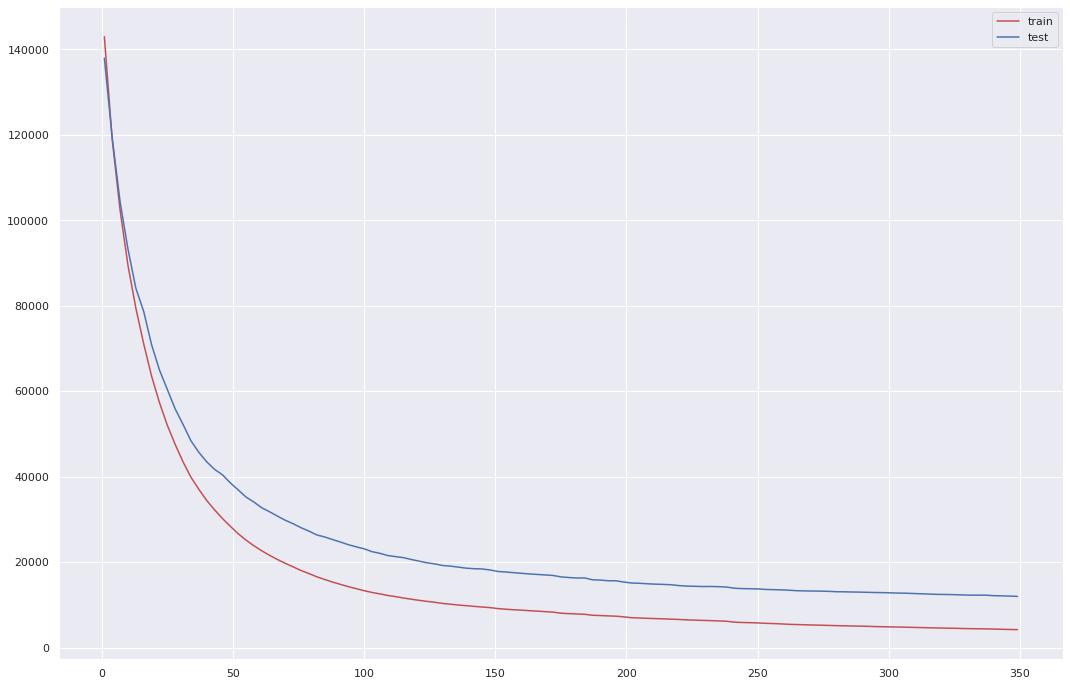

In [ ]:
plt.figure(figsize= (18, 12))

plt.plot(range(1, 350, 3), MSE_train, color = 'r', label = 'train')
plt.plot(range(1, 350, 3), MSE_test, color = 'b', label = 'test')
plt.legend()
plt.show()

Какой вывод можно сделать из графика? Что будет, если выбрать **n_estimators** меньшее или большее относительно того, которое вы получили в десятом задании?

**Ответ:**
Да, точность увеличивается, бузусловно, но постепенно увеличивается и разница между точностями на трейне и тесте, но вскоре разница становится примерно одинаковой. Я выбирал значение *n_estimators* = 43 - точка в окрестности перегиба. Левее же разница на трейне и тесте меньше, но выше и метрика MSE, правее - наоборот. Так что это подтверждает, что мы выбрали оптимальное значение параметра.

В случае возникновения вопросов по заданиям обращайтесь в общий чат.